<a href="https://colab.research.google.com/github/tanzimulhoq/Face_Mask_Detection/blob/main/Training_Model_and_OpenCV_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow

     |████████████████████████████████| 462 kB 7.1 MB/s 


In [ ]:
# Access dataset of google drive from colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Import required libraries
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

**Read first image and show it**

In [ ]:
#Reading image from google drive
image = cv2.imread("/content/drive/MyDrive/Colab Notebooks/Dataset/Face Mask/00000_Mask.jpg")

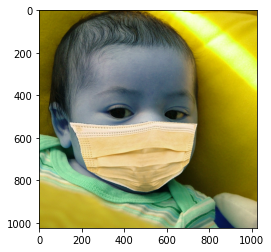

In [ ]:
#Image with distorted color
plt.imshow(image)

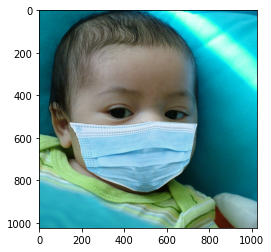

In [ ]:
#Image with actual color
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))

In [ ]:
image.shape

(1024, 1024, 3)

**Generating image one by one at once, with or without mask**

In [ ]:
Directory = "/content/drive/MyDrive/Colab Notebooks/Dataset"

In [ ]:
Classes = ["Face Mask","No Mask"]

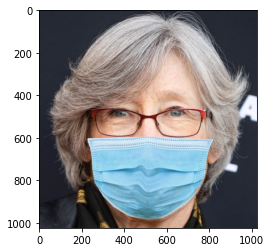

In [ ]:
for categories in Classes:
  path = os.path.join(Directory,categories)
  for img in os.listdir(path):
    image = cv2.imread(os.path.join(path,img))
    plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
    plt.show()
    #If no break statement executed, then first people people with face mask come then people with no face mask as arranged in Classes, 
    #if classes are arranged in another order, images come in that order. If Classes = ["No Mask","Face Mask"] then first comes the people with no mask
    #then people with Face Mask
    break
    #One Person with face mask and one with no mask
  break
  #People with face mask in random order and one by one if the last break statement is executed only
  #If 2 break statements are executed, then one person with face mask comes  

**For Deep Learning, we'll use ImageNet classifier**

In [ ]:
image_size = 224 # ImageNet -. 256 X 256

In [ ]:
new_image_array = cv2.resize(image,(image_size,image_size)) #New image with new size

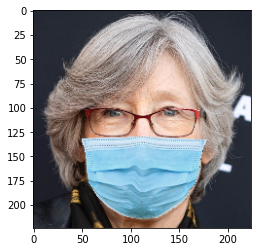

In [ ]:
plt.imshow(cv2.cvtColor(new_image_array,cv2.COLOR_BGR2RGB)) #Display resized image

Read images and convert into arrays to label correctly

In [ ]:
training_data = []

In [ ]:
def create_training_data():
  for categories in Classes:
    path = os.path.join(Directory,categories)
    label_class = Classes.index(categories)   # Label classes as Face mask and without mask through categories "Face Mask" and "No Mask"
    for img in os.listdir(path):
      try:
        image = cv2.imread(os.path.join(path,img))
        new_image_array = cv2.resize(image,(image_size,image_size))
        training_data.append([new_image_array, label_class]) # Runtime error if not written carefully
      except Exception as e:
        pass

In [ ]:
create_training_data()

In [ ]:
print(len(training_data))

1897


In [ ]:
import random

In [ ]:
#We don't want to overfit data 
random.shuffle(training_data)

In [ ]:
X = []  #data
y = []  #label
for features, labels in training_data:
  X.append(features)
  y.append(labels)
X = np.array(X).reshape(-1,image_size,image_size,3) 

In [ ]:
X.shape

(1897, 224, 224, 3)

In [ ]:
#Normalize data
X = X/255.0

**No face mask, output = 0    
 Face Mask,output = 1**

In [ ]:
print(y[0])
print(y[23]) 

1
0


In [ ]:
Y = np.array(y)

In [ ]:
#Save training model and dump it using pickle
import pickle
pickle_out = open("X.pickle","wb")
pickle.dump(X,pickle_out)
pickle_out.close()
pickle_out = open("y.pickle","wb")
pickle.dump(y,pickle_out)
pickle_out.close()

In [ ]:
#Reload model
pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)
pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

**Deep Learning model for training:**
# Transfer Learning

In [ ]:
#Combining all the same stuffs together
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [ ]:
#pre-trained model
model = tf.keras.applications.mobilenet.MobileNet()

17235968/17225924 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                         

In [ ]:
base_input = model.layers[0].input
base_output = model.layers[-4].output

In [ ]:
Flat_layer = layers.Flatten()(base_output)
final_output =layers.Dense(1)(Flat_layer)
final_output = layers.Activation('sigmoid')(final_output)

In [ ]:
new_model = keras.Model(inputs = base_input,outputs = final_output)

In [ ]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

**Binary Classification**

In [ ]:
new_model.compile(loss = "binary_crossentropy",optimizer="adam", metrics=["accuracy"])

In [ ]:
new_model.fit(X,Y,epochs = 1,validation_split = 0.1,batch_size=1)

1707/1707 [==============================] - 666s 388ms/step - loss: 0.0244 - accuracy: 0.9906 - val_loss: 0.0628 - val_accuracy: 0.9789


In [ ]:
new_model.save("my_model1.h5")

In [ ]:
new_model = tf.keras.models.load_model("my_model1.h5")

**Check Network for Predictions**

In [ ]:
frame = cv2.imread('/content/drive/MyDrive/Colab Notebooks/Dataset/No Mask/00038.png')

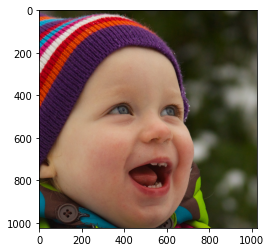

In [ ]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))

In [ ]:
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml') #fearure detection

In [ ]:
frame.shape

(1024, 1024, 3)

In [ ]:
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

In [ ]:
gray.shape

(1024, 1024)

In [ ]:
faces = faceCascade.detectMultiScale(gray,1.1,4) #Four corners of face
for x,y,w,h in faces:
    roi_gray = gray[y:y+h,x:x+w]  #Slices gray area
    roi_color = frame[y:y+h,x:x+w] #Select region based on color
    cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2) #Marks a rectangle of which part to crop as shown below
    facess = faceCascade.detectMultiScale(roi_gray)
    if len(facess) == 0:
        print("Face not detcted")
    else:
        for (ex,ey,ew,eh) in facess:
            face_roi = roi_color[ey:ey+eh,ex: ex+ew] #Face cropped and converted to color if detected

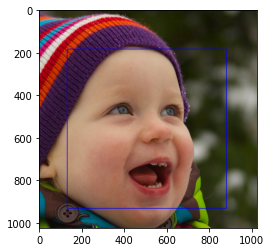

In [ ]:
plt.imshow(cv2.cvtColor(frame,cv2.COLOR_BGR2RGB))
#Actual image

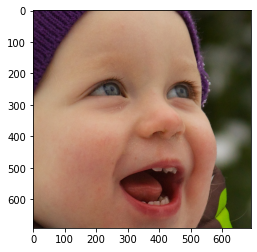

In [ ]:
plt.imshow(cv2.cvtColor(face_roi,cv2.COLOR_BGR2RGB)) #Cropped one

In [ ]:
final_image = cv2.resize(face_roi,(224,224))

In [ ]:
final_image = np.expand_dims(final_image, axis = 0) #Increasing one dimension to avoid error

In [ ]:
final_image = final_image/255.0

In [ ]:
Predictions = new_model.predict(final_image)

In [ ]:
Predictions

array([[0.68006426]], dtype=float32)

In [ ]:
if Predictions >=0.68:
  print("No mask")
else:
  print("mask")

No mask


In [ ]:
!pip install opencv-contrib-python
!pip install deepface

In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# initialize the Haar Cascade face detection model
face_cascade = cv2.CascadeClassifier(cv2.samples.findFile(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml'))

In [ ]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data) 
  # grayscale img
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  print(gray.shape)
  # get face bounding box coordinates using Haar Cascade
  faces = face_cascade.detectMultiScale(gray)
  # draw face bounding box on image
  for (x,y,w,h) in faces:
      img = cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
  # save image
  cv2.imwrite(filename, img)

  return filename

Can take photo and detect mask


In [ ]:
try:
  filename = take_photo('photo.jpg')
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

Can stream video to detect mask


In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
        break

    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    # create transparent overlay for bounding box
    bbox_array = np.zeros([480,640,4], dtype=np.uint8)

    # grayscale image for face detection
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    # get face region coordinates
    faces = face_cascade.detectMultiScale(gray)
    # get face bounding box for overlay
    for (x,y,w,h) in faces:
      bbox_array = cv2.rectangle(bbox_array,(x,y),(x+w,y+h),(255,0,0),2)
      if len(faces)!= 0:
        frame = img
        new_model = tf.keras.models.load_model("my_model1.h5")
        roi_gray = gray[y:y+h,x:x+w]
        roi_color = frame[y:y+h,x:x+w]
        cv2.rectangle(frame,(x,y),(x+w,y+h),(255,0,0),2)
        facess = faceCascade.detectMultiScale(roi_gray)
        if len(facess) == 0:
            print("Face not detcted")
        else:
            for (ex,ey,ew,eh) in facess:
                face_roi = roi_color[ey:ey+eh,ex: ex+ew]
        final_image = cv2.resize(face_roi,(224,224))
        final_image = np.expand_dims(final_image,axis=0)
        final_image = final_image/255.0
        Predictions = new_model.predict(final_image)
        print(Predictions)


    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>

[[0.9341303]]
[[0.5261847]]
[[0.5560151]]
Face not detcted
[[0.5560151]]
Face not detcted
[[0.5560151]]
[[0.59157443]]
Face not detcted
[[0.59157443]]
Face not detcted
[[0.59157443]]
Face not detcted
[[0.59157443]]
Face not detcted
[[0.59157443]]
Face not detcted
[[0.59157443]]
[[0.4982753]]
Face not detcted
[[0.4982753]]
Face not detcted
[[0.4982753]]
Face not detcted
[[0.4982753]]
Face not detcted
[[0.4982753]]
Face not detcted
[[0.4982753]]
Face not detcted
[[0.4982753]]
Face not detcted
[[0.4982753]]
Face not detcted
[[0.4982753]]
[[0.71941036]]
Face not detcted
[[0.71941036]]
Face not detcted
[[0.71941036]]
Face not detcted
[[0.71941036]]
Face not detcted
[[0.71941036]]
Face not detcted
[[0.71941036]]
[[0.98595047]]
Face not detcted
[[0.98595047]]
Face not detcted
[[0.98595047]]
Face not detcted
[[0.98595047]]
Face not detcted
[[0.98595047]]
[[0.99974334]]
Face not detcted
[[0.99974334]]
Face not detcted
[[0.99974334]]
Face not detcted
[[0.99974334]]
Face not detcted
[[0.99974334]